In [20]:
# Librerias necesarias 
import os
import time
import csv
import re
import unicodedata
from collections import Counter
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## SCRAPPING

In [21]:
import csv
import requests
from bs4 import BeautifulSoup

###########################
# Formatear fecha
###########################

meses = {
    "enero": "01",
    "febrero": "02",
    "marzo": "03",
    "abril": "04",
    "mayo": "05",
    "junio": "06",
    "julio": "07",
    "agosto": "08",
    "septiembre": "09",
    "octubre": "10",
    "noviembre": "11",
    "diciembre": "12",
}

def limpiar_fecha(fecha_raw, meses):
    if not fecha_raw:
        return ""

    fecha_limpieza = fecha_raw.replace("Escrito en", "").strip()
    separar = fecha_limpieza.replace(" de ", " ")

    for mes, num_mes in meses.items():
        if mes in separar:
            separar = separar.replace(mes, num_mes)
            break

    try:
        dia, mes, anio = separar.split()
        return f"{dia.zfill(2)}-{mes}-{anio}"
    except ValueError:
        return ""

###########################
# URLs 
###########################

urls = {
    "Vitoria": "https://www.booking.com/reviews/es/hotel/libere-vitoria-centro.es.html",
    "Donosti": "https://www.booking.com/reviews/es/hotel/koisi-hostel.es.html",
    "BilbaoMuseo": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-bilbao-guggenheim.es.html",
    "BilbaoLaVieja": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-bilbao-la-vieja.es.html",
    "ValenciaAbastos": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-valencia-abastos.es.html",
    "PamplonaYamaguchi": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-pamplona-yamaguchi.es.html",
    "ValenciaJardinBotanico": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-valencia-jardin-botanico.es.html",
    "MadridPalacioReal": "https://www.booking.com/reviews/es/hotel/libere-madrid-palacio-real.es.html",
    "MalagaTeatroRomano": "https://www.booking.com/reviews/es/hotel/apartamentosliberemalagateatroromano.es.html",
    "GranadaCatedral": "https://www.booking.com/reviews/es/hotel/apartamentos-libere-granada-catedral.es.html",
    "MalagaLaMerced": "https://www.booking.com/reviews/es/hotel/libere-malaga-la-merced.es.html",
    "CordobaPatio": "https://www.booking.com/reviews/es/hotel/libere-cordoba-patio-santa-marta.es.html",
}

archivo_csv = open("../../Datos/DatosTransformados/comentarios_booking.csv", "w", encoding="utf-8")
writer = csv.writer(archivo_csv)

cabecera = [
    "ubicacion",
    "fecha",
    "puntuacion",
    "titulo_comentario",
    "comentario_negativo",
    "comentario_positivo",
    "etiquetas"
]

archivo_csv.write(",".join(cabecera) + "\n")

###########################
# Scraping
###########################

for nombre_lugar in urls:
    url_base = urls[nombre_lugar]
    pagina_actual = 1

    while True:
        url_pagina = url_base + "?page=" + str(pagina_actual)
        respuesta = requests.get(url_pagina)
        html = BeautifulSoup(respuesta.text, "lxml")

        reseñas = html.select("li.review_item.clearfix")
        if not reseñas:
            break

        for r in reseñas:
            elemento_fecha = r.select_one("p.review_item_date")
            texto_fecha = elemento_fecha.get_text(strip=True) if elemento_fecha else ""
            fecha = limpiar_fecha(texto_fecha, meses)

            elemento_puntuacion = r.select_one("span.review-score-badge")
            puntuacion = elemento_puntuacion.get_text(strip=True) if elemento_puntuacion else ""

            elemento_titulo = r.select_one("span[itemprop='name']")
            titulo = elemento_titulo.get_text(strip=True) if elemento_titulo else ""

            elemento_negativo = r.select_one("p.review_neg span[itemprop='reviewBody']")
            comentario_negativo = elemento_negativo.get_text(strip=True) if elemento_negativo else ""

            elemento_positivo = r.select_one("p.review_pos span[itemprop='reviewBody']")
            comentario_positivo = elemento_positivo.get_text(strip=True) if elemento_positivo else ""

            lista_etiquetas = r.select("ul.review_item_info_tags li")
            etiquetas_texto = ""
            for e in lista_etiquetas:
                etiquetas_texto += e.get_text().replace("•", "").strip() + " | "
            etiquetas_texto = etiquetas_texto[:-3]

            writer.writerow([
                nombre_lugar,
                fecha,
                puntuacion,
                titulo,
                comentario_negativo,
                comentario_positivo,
                etiquetas_texto
            ])

        pagina_actual += 1

archivo_csv.close()


In [22]:
df = pd.read_csv("../../Datos/DatosTransformados/comentarios_booking.csv")
df.head()

,ubicacion,fecha,puntuacion,titulo_comentario,comentario_negativo,comentario_positivo,etiquetas
0,Vitoria,03-01-2026,"9,0",Helenca,NaN,Las instalaciones eran nuevas y modernas,Viaje de ocio | Grupo | Apartamento de 1 dormi...
1,Vitoria,02-01-2026,"9,0",Andrea,Lo peor que tiene el apartamento es el sofá ca...,El apartamento está muy nuevo y limpio. Tal cu...,Viaje de ocio | Familia con niños pequeños | A...
2,Vitoria,01-01-2026,"9,0",Xavier,NaN,Instalaciones nuevas y comodas,Viaje de ocio | Familia con niños pequeños | A...
3,Vitoria,29-12-2025,"8,0",Raquel,La persona que duerme en el sofá cama está alg...,Muy amplio y preparado,Viaje de ocio | Familia con niños pequeños | A...
4,Vitoria,22-12-2025,"8,0",Juan,"Las habitaciones, se suponía que constaba el a...",La ubicación,Viaje de ocio | Grupo | Apartamento de 2 dormi...


In [23]:
# Miramos que los tipos de datos esten correctamente 
df.dtypes

ubicacion              object
fecha                  object
puntuacion             object
titulo_comentario      object
comentario_negativo    object
comentario_positivo    object
etiquetas              object
dtype: object

##### Vemos como la fecha y la puntuacion no estan en el formato que tienen que estar, por eso pondremos la fecha en formato datetime y la puntuacion en float

In [24]:
df['fecha'] = pd.to_datetime(df['fecha'],format='%d-%m-%Y')

In [25]:
df['puntuacion'] = (df['puntuacion'].astype(str).str.replace(',', '.', regex=False))
df['puntuacion'] = pd.to_numeric(df['puntuacion'])


## GRAFICANDO

#### Grafico 1

In [26]:
puntuacion_media_hotel = (df.groupby('ubicacion')['puntuacion'].mean().sort_values().reset_index())
puntuacion_media_hotel['puntuacion'] = puntuacion_media_hotel['puntuacion'].round(2)

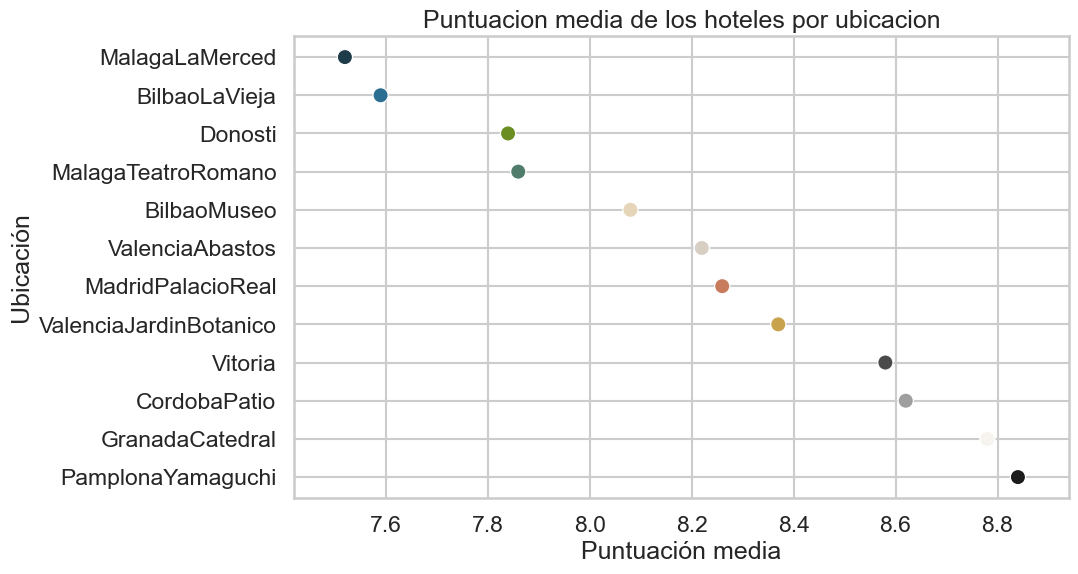

In [27]:
# Asignamos una paleta con al menos 12 colores uno por ubicacion
paleta = [
    "#1F3C4B", "#2C6E91", "#6B8E23", "#4F7C6B",
    "#E6D5B8", "#D8CFC4", "#C97C5D", "#C9A24D",
    "#4A4A4A", "#9E9E9E", "#F7F4EF", "#1C1C1C"
]


ubicaciones = puntuacion_media_hotel['ubicacion'].unique()
color_por_ubicacion = dict(zip(ubicaciones, paleta))

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10,6))

sns.scatterplot(
    data=puntuacion_media_hotel,
    x='puntuacion',
    y='ubicacion',
    hue='ubicacion',
    palette=color_por_ubicacion,
    s=120,
    legend=False
)

plt.title("Puntuacion media de los hoteles por ubicacion")
plt.xlabel("Puntuación media")
plt.ylabel("Ubicación")

xmin = puntuacion_media_hotel['puntuacion'].min() - 0.1
xmax = puntuacion_media_hotel['puntuacion'].max() + 0.1
plt.xlim(xmin, xmax)
plt.show()

#### Grafico 2

In [28]:
# Contar cuantas reseñas tiene cada hotel
resumen_hotel = (df.groupby('ubicacion').agg(puntuacion_media=('puntuacion', 'mean'),num_reseñas=('puntuacion', 'count')).reset_index())


C:\Users\togui\AppData\Local\Temp\ipykernel_11492\3408049124.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Ubicación')

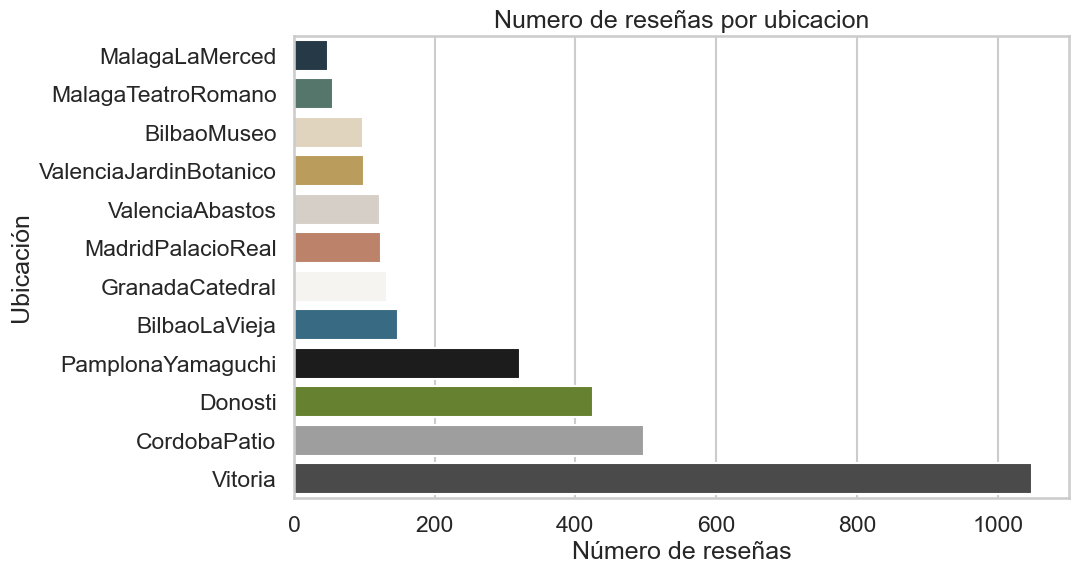

In [29]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10,6))

sns.barplot(
    data=resumen_hotel.sort_values('num_reseñas'),
    x='num_reseñas',
    y='ubicacion',
    palette=color_por_ubicacion
)

plt.title("Numero de reseñas por ubicacion")
plt.xlabel("Número de reseñas")
plt.ylabel("Ubicación")


#### Grafico 3

En este grafico se puede ver la relacion entre la puntuacion media de cada hotel y el numero de reseñas que ha recibido. En el eje x se muestra la cantidad de opiniones, lo que nos ayuda a entender hasta que punto la puntuacion es fiable, mientras que en el eje y aparece la puntuacion media.

Este grafico nos permite entender entre los hoteles que tienen una puntuacion alta pero pocas reseñas, donde las valoracion puede no ser del todo representativa, y aquellos que cuentan con muchas reseñas y aun asi presentan una puntuacion mas baja, lo que indica que los problemas detectados son recurrentes.

(0.0, 10.0)

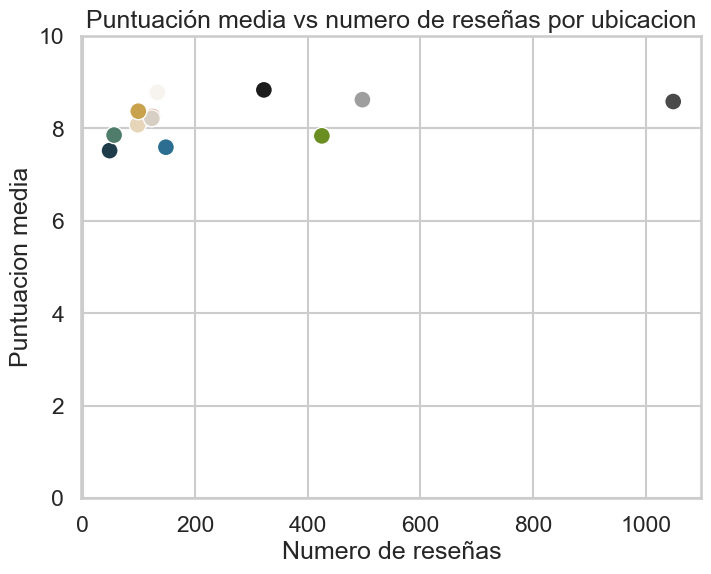

In [30]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=resumen_hotel,
    x='num_reseñas',
    y='puntuacion_media',
    hue='ubicacion',
    palette=color_por_ubicacion,
    s=150,
    legend=False
)

plt.title("Puntuación media vs numero de reseñas por ubicacion")
plt.xlabel("Numero de reseñas")
plt.ylabel("Puntuacion media")
plt.ylim(0, 10)

## Conclusion del analisis exploratorio

Una vez analizados los tres graficos anteriores, podemos llegar a una conclusion bastante clara. El objetivo es seleccionar dos hoteles cuya puntuacion media sea relativamente baja respecto al resto, pero que al mismo tiempo cuenten con un numero de reseñas considerable, ya que una puntuacion alta o baja basada en pocas opiniones no resulta demasiado fiable.

Siguiendo este criterio, se han escogido dos hoteles como casos prioritarios para el analisis:

- **BilbaoLaVieja**: es el hotel con la puntuacion media mas baja de todo el conjunto y ademas cuenta con un numero significativo de reseñas. Esto indica que la valoracion baja no es algo puntual, sino que responde a problemas recurrentes en la experiencia de los huespedes.

- **Donosti**: aunque no es el hotel peor valorado, presenta una puntuacion media mas baja en comparacion con otros hoteles que tienen una cantidad de reseñas similar. Al acumular mas de 400 opiniones, su valoracion puede considerarse muy fiable, lo que lo convierte en un buen candidato para proponer mejoras.

Por tanto, estos dos hoteles son los mas adecuados para profundizar en el analisis de los comentarios y plantear recomendaciones orientadas a mejorar la satisfaccion de los huespedes.


-------------------------------------------------------------------------------------------------------------------

#### Grafico 4

Limpieza de texto

In [31]:
df["comentario_negativo"] = df["comentario_negativo"].fillna("")
df["comentario_positivo"] = df["comentario_positivo"].fillna("")

stopwords = [
    "de", "la", "el", "y", "a", "en", "que", "es", "un", "una",
    "por", "para", "con", "no", "se", "los", "las", "muy",
    "todo", "mas", "menos", "pero", "tambien", "ya",
    "al", "del", "lo", "le", "les", "me", "nos", "hay", "q",
    "te", "do", "ni", "era", "si", "porque", "esta", "nada",
    "cuando", "mi", "su", "sus", "como", "asi", "fue", "sin",
    "estaba", "habia", "estan", "estar", "ser", "ademas", "super", 
    "bien", "mucho", "poco", "algo", "solo", "dos", "tenia", "falta", 
    "buena", "sin", "estaba", "poco", "dia", "hasta", "aunque", "bastante",
    "puede"
]

def quitar_tildes(texto):
    texto_normal = unicodedata.normalize("NFD", texto)
    texto_sin_tildes = ""

    for c in texto_normal:
        if unicodedata.category(c) != "Mn":
            texto_sin_tildes += c

    return texto_sin_tildes

def limpiar_texto(texto):
    texto = texto.lower()
    texto = quitar_tildes(texto)

    texto_limpio = ""
    for c in texto:
        if c.isalpha() or c == " ":
            texto_limpio += c

    palabras = texto_limpio.split()

    palabras_finales = []
    for p in palabras:
        if p.endswith("s"):
            p = p[:-1]
        if p not in stopwords and len(p) > 2:
            palabras_finales.append(p)

    return palabras_finales


Funcion para contar palabras

In [32]:
def contar_palabras(columna):
    conteo = {}

    for texto in columna:
        palabras = limpiar_texto(texto)

        for p in palabras:
            if p in conteo:
                conteo[p] += 1
            else:
                conteo[p] = 1

    return conteo


Global Negativos

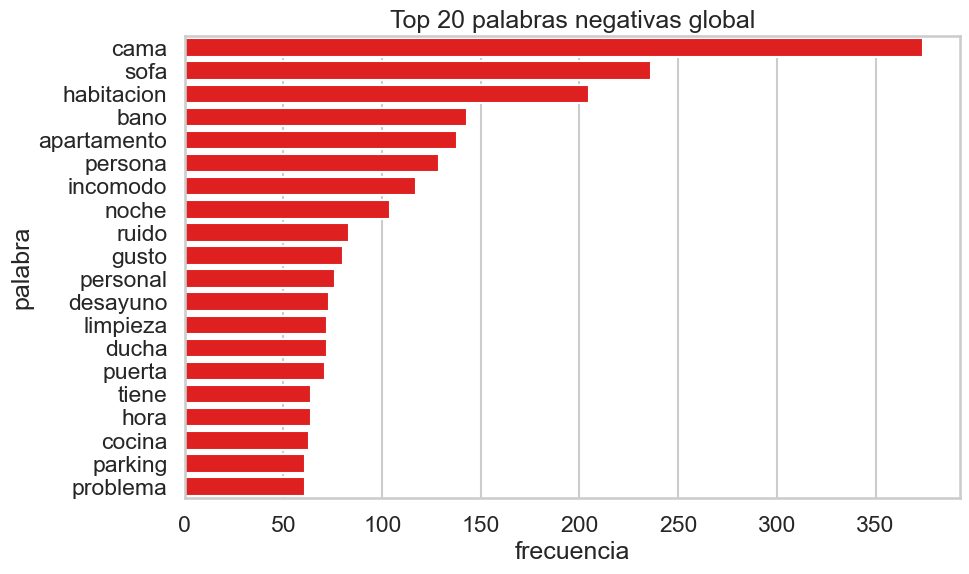

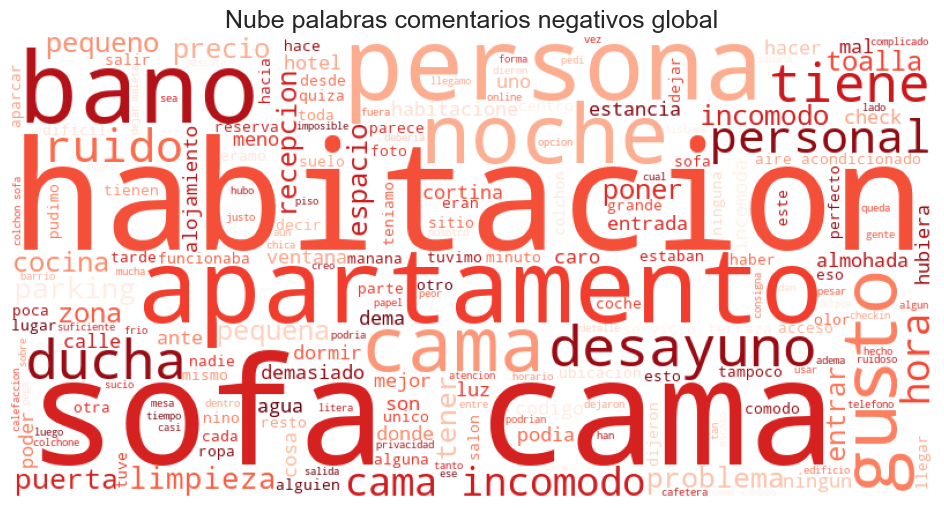

In [33]:
freq_neg = contar_palabras(df["comentario_negativo"])
lista_neg = list(freq_neg.items())
lista_neg.sort(key=lambda x: x[1], reverse=True)

top_neg = lista_neg[:20]
df_neg = pd.DataFrame(top_neg, columns=["palabra", "frecuencia"])

plt.figure(figsize=(10,6))
sns.barplot(data=df_neg, x="frecuencia", y="palabra", color="red")
plt.title("Top 20 palabras negativas global")
plt.show()

texto_neg = ""
for t in df["comentario_negativo"]:
    palabras = limpiar_texto(t)
    for p in palabras:
        texto_neg += p + " "

wc_neg = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds"
).generate(texto_neg)

plt.figure(figsize=(12,6))
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Nube palabras comentarios negativos global")
plt.show()

Global Positivos

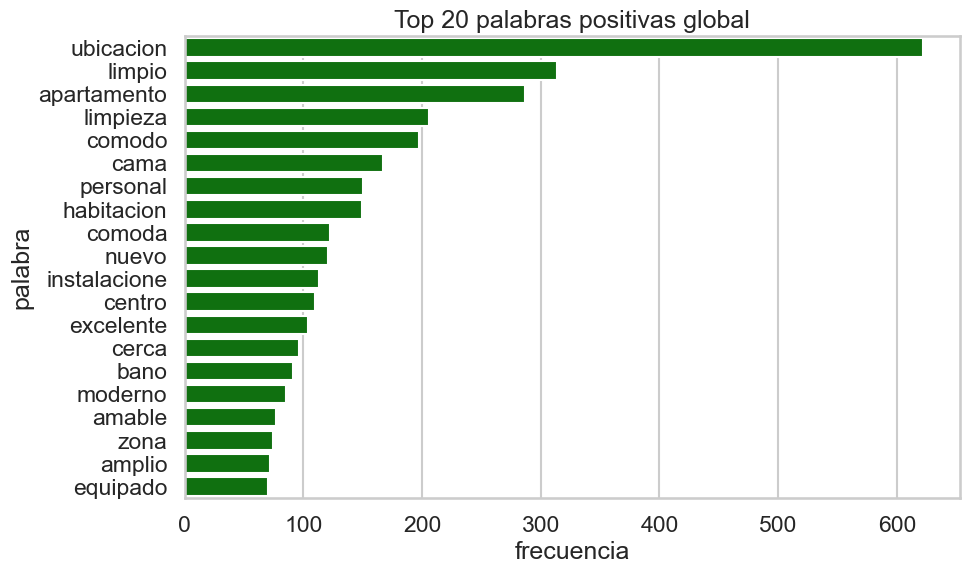

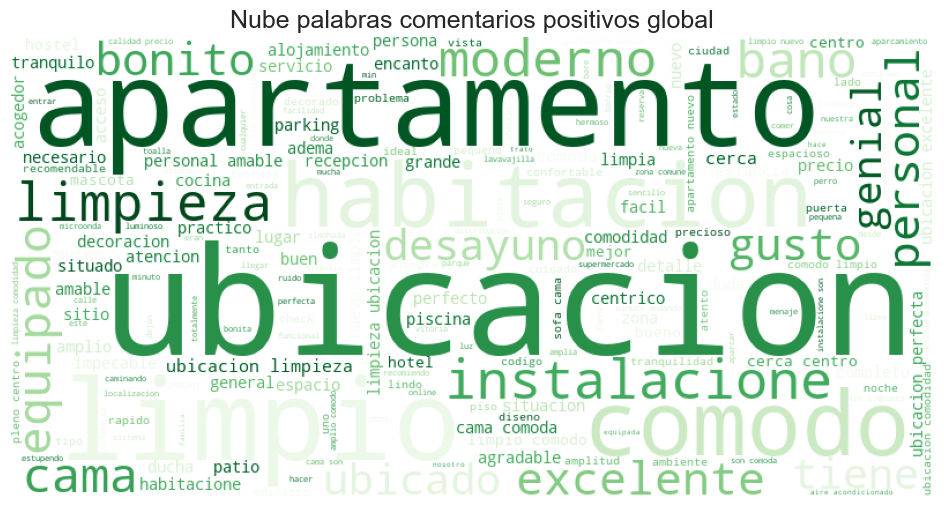

In [34]:
freq_pos = contar_palabras(df["comentario_positivo"])
lista_pos = list(freq_pos.items())
lista_pos.sort(key=lambda x: x[1], reverse=True)

top_pos = lista_pos[:20]
df_pos = pd.DataFrame(top_pos, columns=["palabra", "frecuencia"])

plt.figure(figsize=(10,6))
sns.barplot(data=df_pos, x="frecuencia", y="palabra", color="green")
plt.title("Top 20 palabras positivas global")
plt.show()

texto_pos = ""
for t in df["comentario_positivo"]:
    palabras = limpiar_texto(t)
    for p in palabras:
        texto_pos += p + " "

wc_pos = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Greens"
).generate(texto_pos)

plt.figure(figsize=(12,6))
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Nube palabras comentarios positivos global")
plt.show()

Bilbao y Donosti

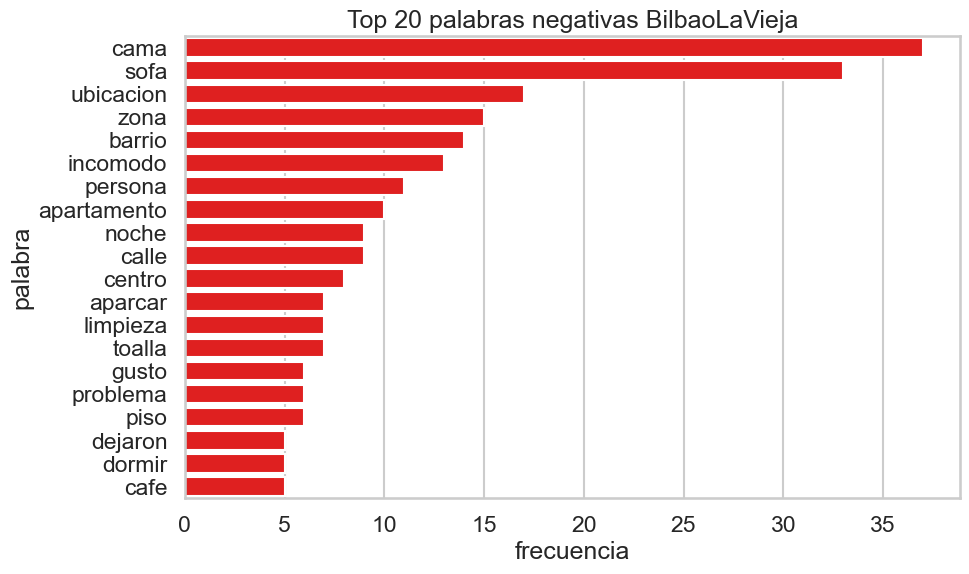

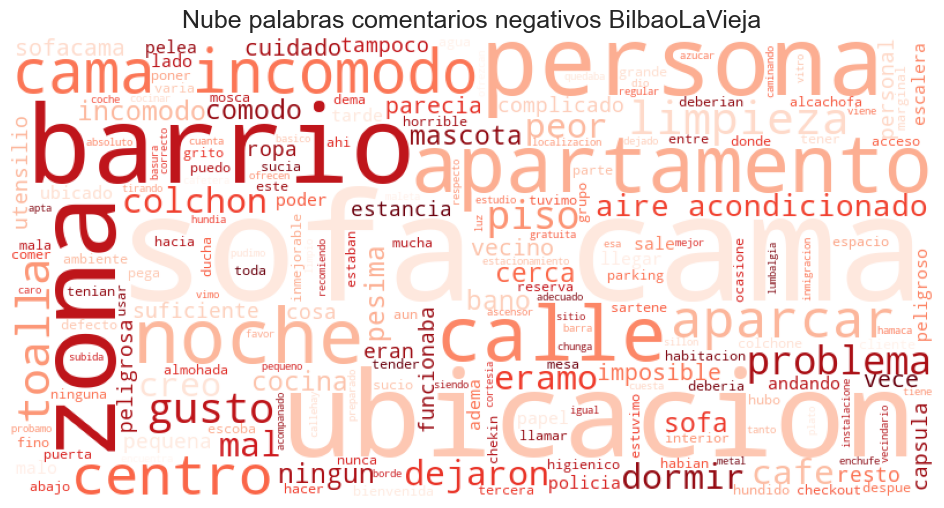

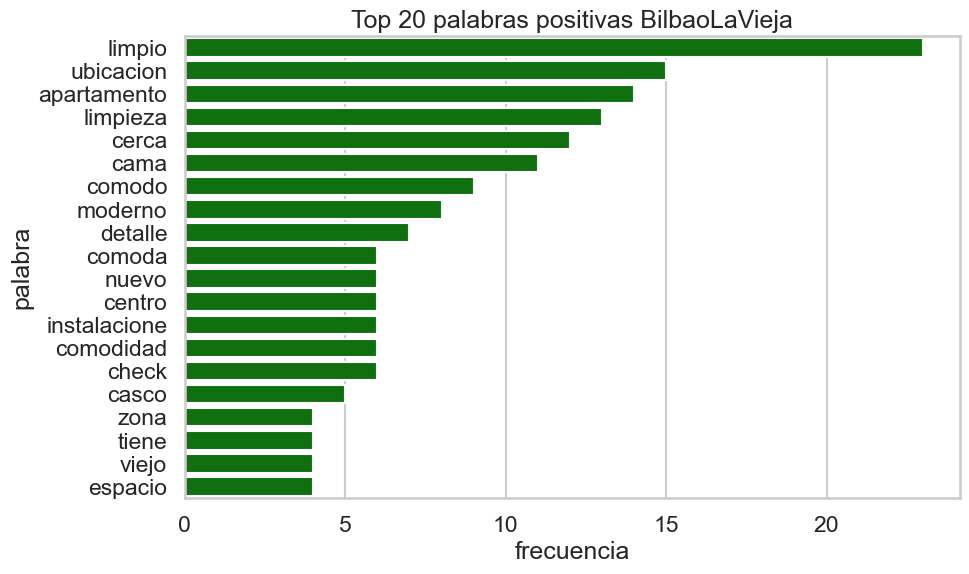

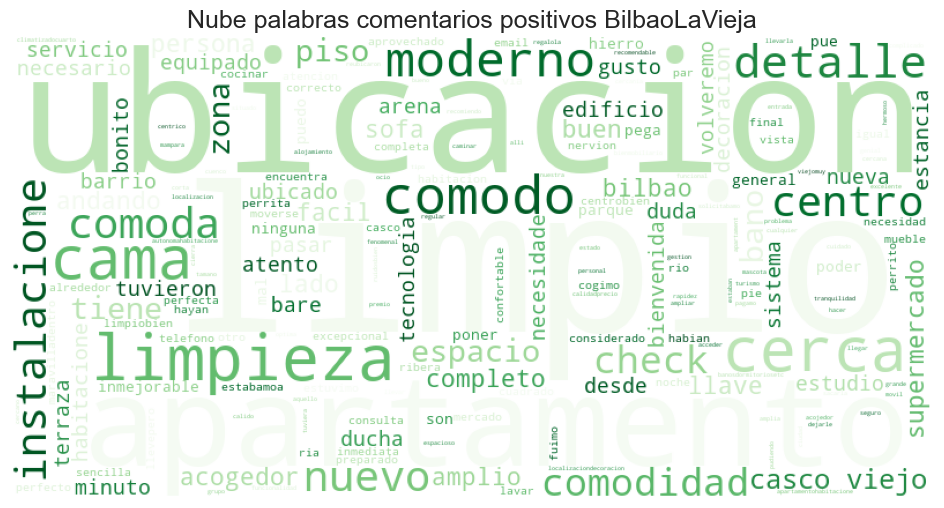

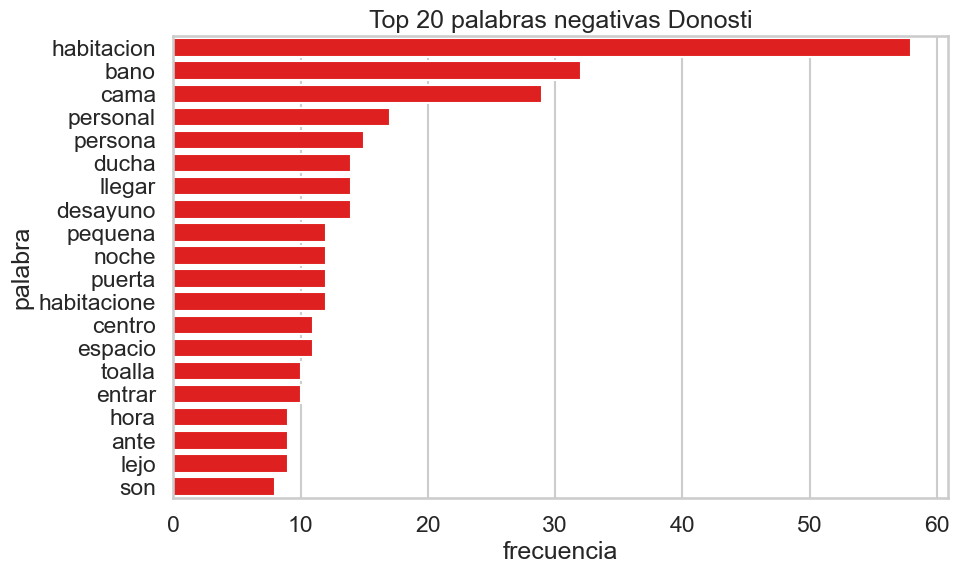

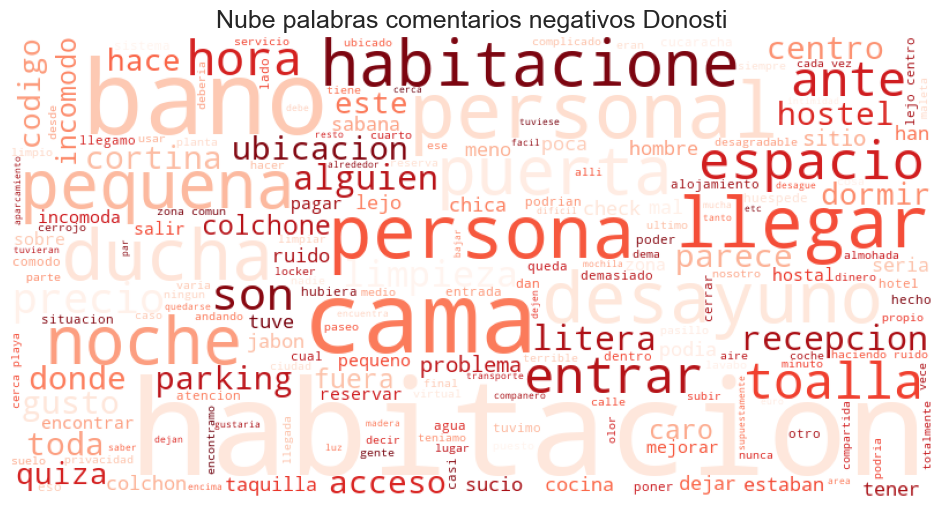

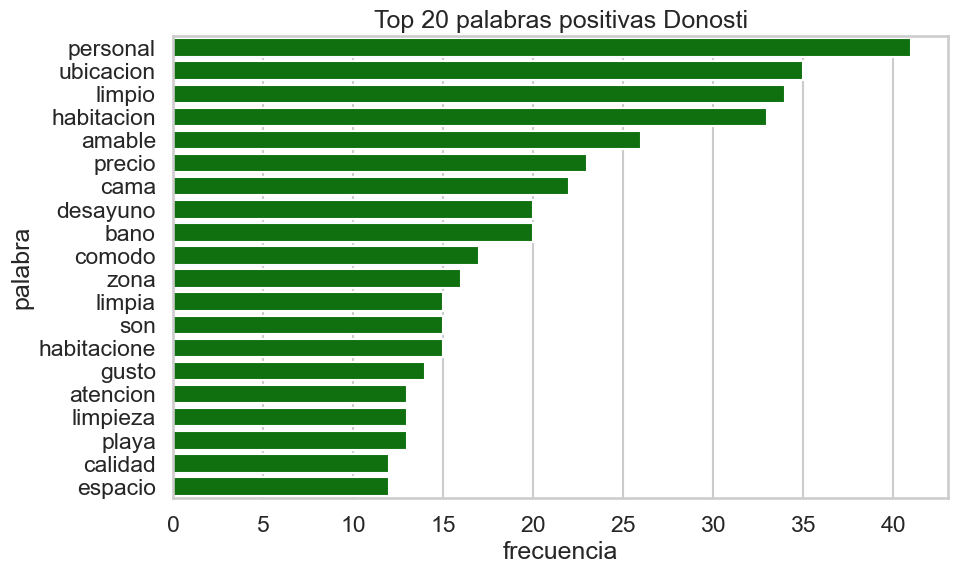

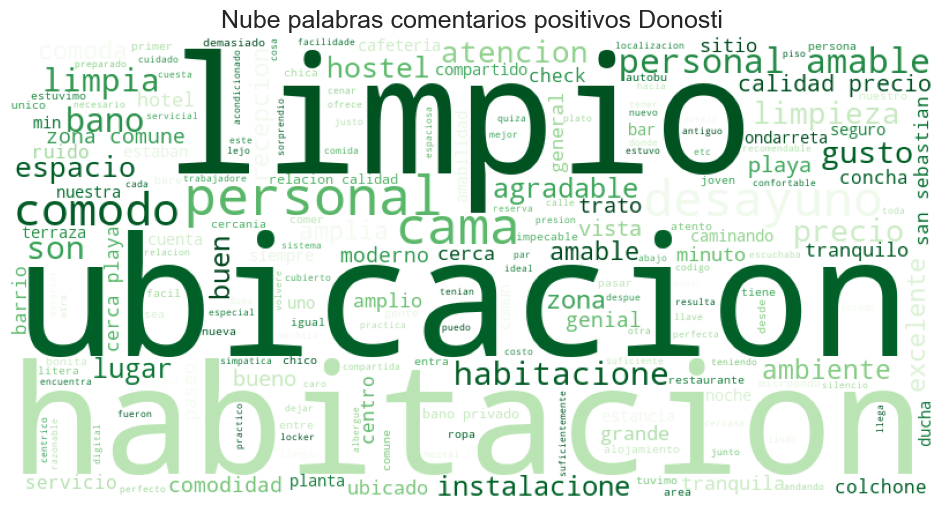

In [35]:
hoteles = ["BilbaoLaVieja", "Donosti"]

for hotel in hoteles:

    df_hotel = df[df["ubicacion"] == hotel]

    # Negativos
    freq_neg_h = contar_palabras(df_hotel["comentario_negativo"])
    lista_neg_h = list(freq_neg_h.items())
    lista_neg_h.sort(key=lambda x: x[1], reverse=True)

    top_neg_h = lista_neg_h[:20]
    df_neg_h = pd.DataFrame(top_neg_h, columns=["palabra", "frecuencia"])

    plt.figure(figsize=(10,6))
    sns.barplot(data=df_neg_h, x="frecuencia", y="palabra", color="red")
    plt.title("Top 20 palabras negativas " + hotel)
    plt.show()

    texto_neg_h = ""
    for t in df_hotel["comentario_negativo"]:
        palabras = limpiar_texto(t)
        for p in palabras:
            texto_neg_h += p + " "

    wc_neg_h = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="Reds"
    ).generate(texto_neg_h)

    plt.figure(figsize=(12,6))
    plt.imshow(wc_neg_h)
    plt.axis("off")
    plt.title("Nube palabras comentarios negativos " + hotel)
    plt.show()

    # Positivos 
    freq_pos_h = contar_palabras(df_hotel["comentario_positivo"])
    lista_pos_h = list(freq_pos_h.items())
    lista_pos_h.sort(key=lambda x: x[1], reverse=True)

    top_pos_h = lista_pos_h[:20]
    df_pos_h = pd.DataFrame(top_pos_h, columns=["palabra", "frecuencia"])

    plt.figure(figsize=(10,6))
    sns.barplot(data=df_pos_h, x="frecuencia", y="palabra", color="green")
    plt.title("Top 20 palabras positivas " + hotel)
    plt.show()

    texto_pos_h = ""
    for t in df_hotel["comentario_positivo"]:
        palabras = limpiar_texto(t)
        for p in palabras:
            texto_pos_h += p + " "

    wc_pos_h = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="Greens"
    ).generate(texto_pos_h)

    plt.figure(figsize=(12,6))
    plt.imshow(wc_pos_h)
    plt.axis("off")
    plt.title("Nube palabras comentarios positivos " + hotel)
    plt.show()


#### Grafico 5

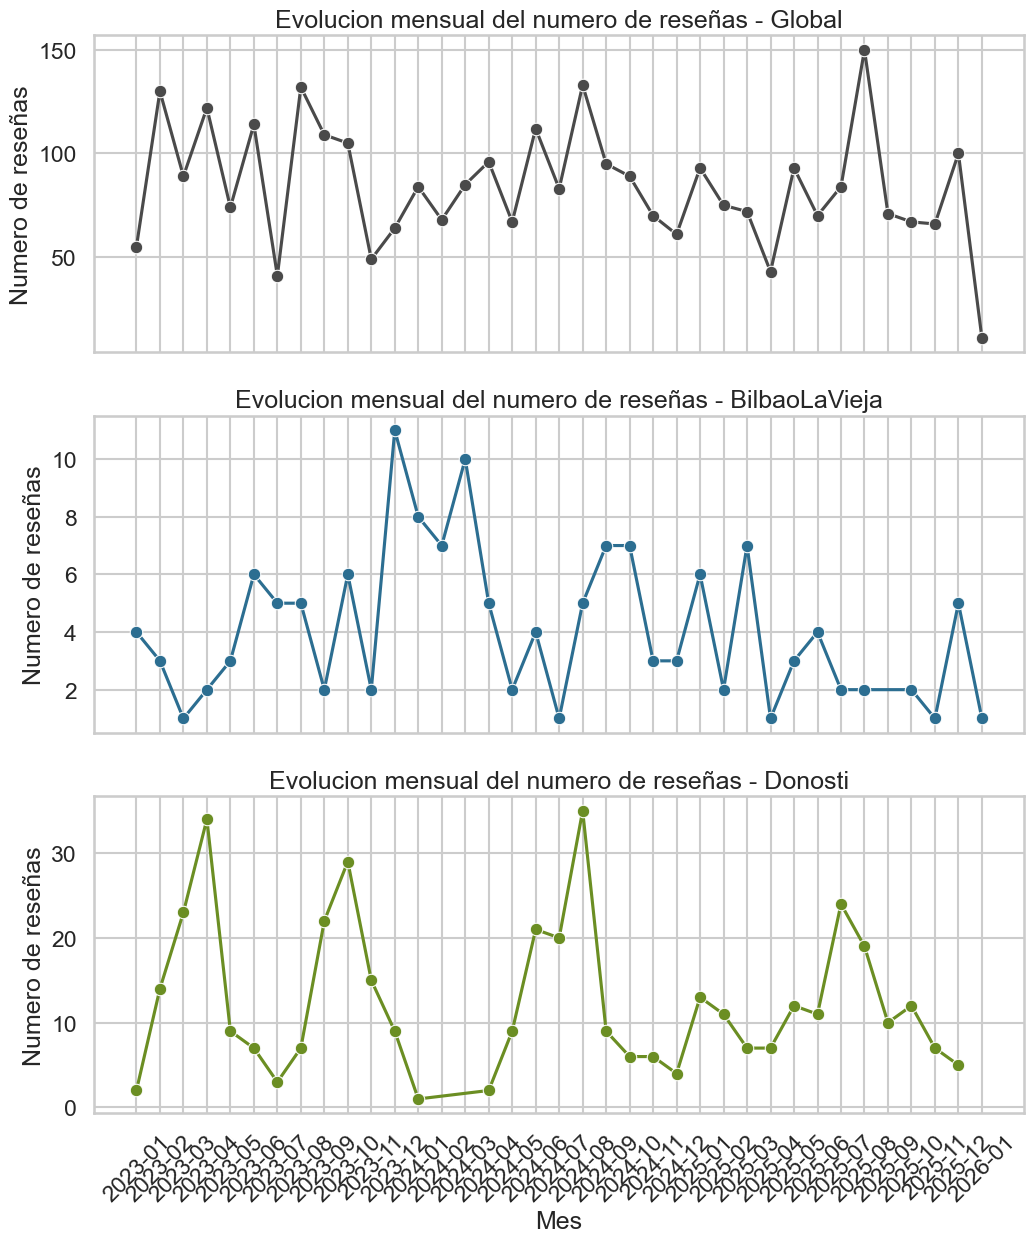

In [36]:

df["mes"] = df["fecha"].dt.to_period("M").astype(str)

reseñas_global = (
    df.groupby("mes")
    .size()
    .reset_index(name="num_reseñas")
)

reseñas_hoteles = (
    df[df["ubicacion"].isin(hoteles)]
    .groupby(["mes", "ubicacion"])
    .size()
    .reset_index(name="num_reseñas")
)

sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=True)

# General
sns.lineplot(
    data=reseñas_global,
    x="mes",
    y="num_reseñas",
    marker="o",
    ax=axes[0],
    color=paleta[8]   
)
axes[0].set_title("Evolucion mensual del numero de reseñas - Global")
axes[0].set_ylabel("Numero de reseñas")

# BilbaoLaVieja
sns.lineplot(
    data=reseñas_hoteles[reseñas_hoteles["ubicacion"] == "BilbaoLaVieja"],
    x="mes",
    y="num_reseñas",
    marker="o",
    ax=axes[1],
    color=color_por_ubicacion["BilbaoLaVieja"]
)
axes[1].set_title("Evolucion mensual del numero de reseñas - BilbaoLaVieja")
axes[1].set_ylabel("Numero de reseñas")

# Donosti
sns.lineplot(
    data=reseñas_hoteles[reseñas_hoteles["ubicacion"] == "Donosti"],
    x="mes",
    y="num_reseñas",
    marker="o",
    ax=axes[2],
    color=color_por_ubicacion["Donosti"]
)
axes[2].set_title("Evolucion mensual del numero de reseñas - Donosti")
axes[2].set_ylabel("Numero de reseñas")
axes[2].set_xlabel("Mes")

plt.xticks(rotation=45)
plt.show()


#### Grafico 6

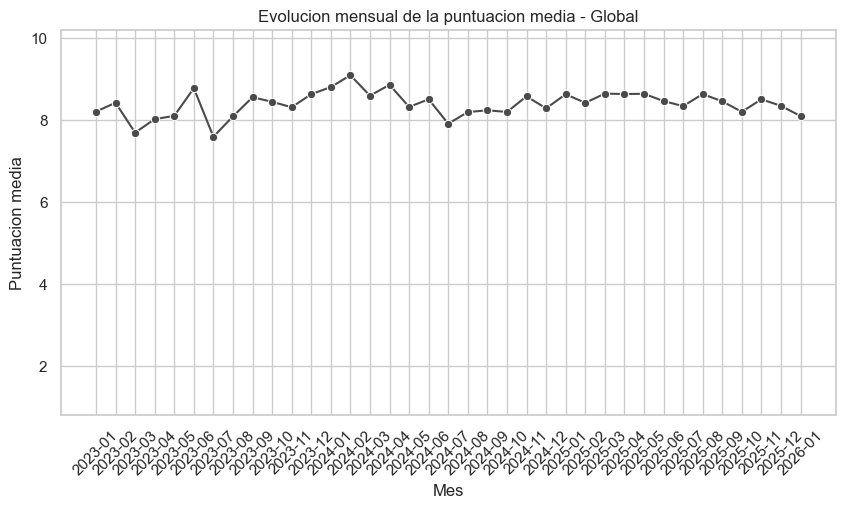

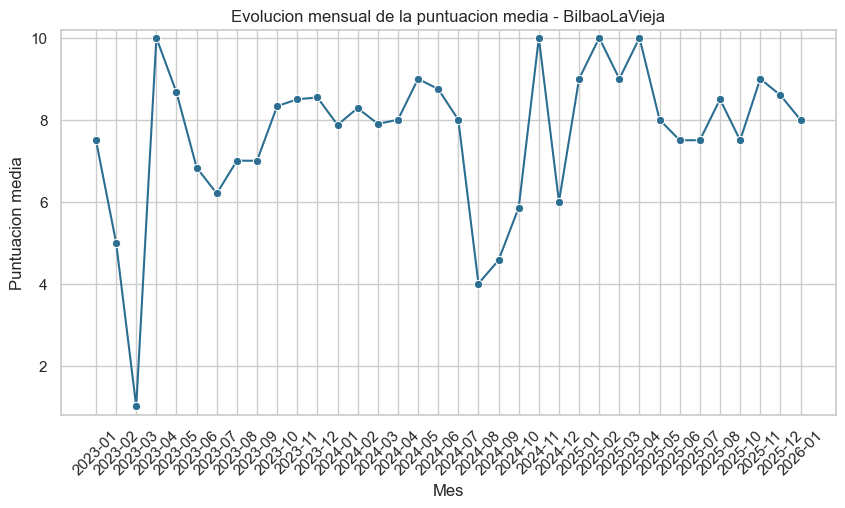

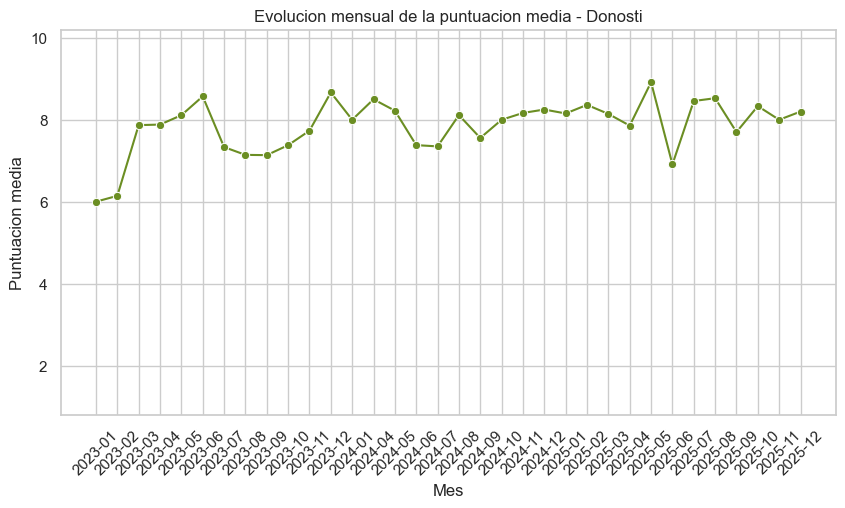

In [37]:
sns.set(style="whitegrid")

ymin = df["puntuacion"].min() - 0.2
ymax = df["puntuacion"].max() + 0.2

# Global
media_global = (
    df.groupby("mes")["puntuacion"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=media_global,
    x="mes",
    y="puntuacion",
    marker="o",
    color=paleta[8]   
)

plt.title("Evolucion mensual de la puntuacion media - Global")
plt.xlabel("Mes")
plt.ylabel("Puntuacion media")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45)
plt.show()

# BilbaoLaVieja
media_bilbao = (
    df[df["ubicacion"] == "BilbaoLaVieja"]
    .groupby("mes")["puntuacion"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=media_bilbao,
    x="mes",
    y="puntuacion",
    marker="o",
    color=color_por_ubicacion["BilbaoLaVieja"]
)

plt.title("Evolucion mensual de la puntuacion media - BilbaoLaVieja")
plt.xlabel("Mes")
plt.ylabel("Puntuacion media")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45)
plt.show()

# Donosti
media_donosti = (
    df[df["ubicacion"] == "Donosti"]
    .groupby("mes")["puntuacion"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=media_donosti,
    x="mes",
    y="puntuacion",
    marker="o",
    color=color_por_ubicacion["Donosti"]
)

plt.title("Evolucion mensual de la puntuacion media - Donosti")
plt.xlabel("Mes")
plt.ylabel("Puntuacion media")
plt.ylim(ymin, ymax)
plt.xticks(rotation=45)
plt.show()


#### Grafico 7

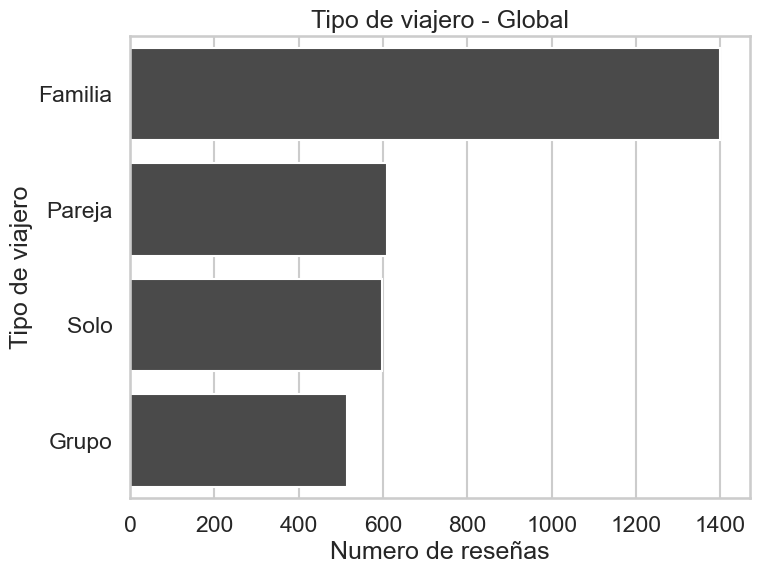

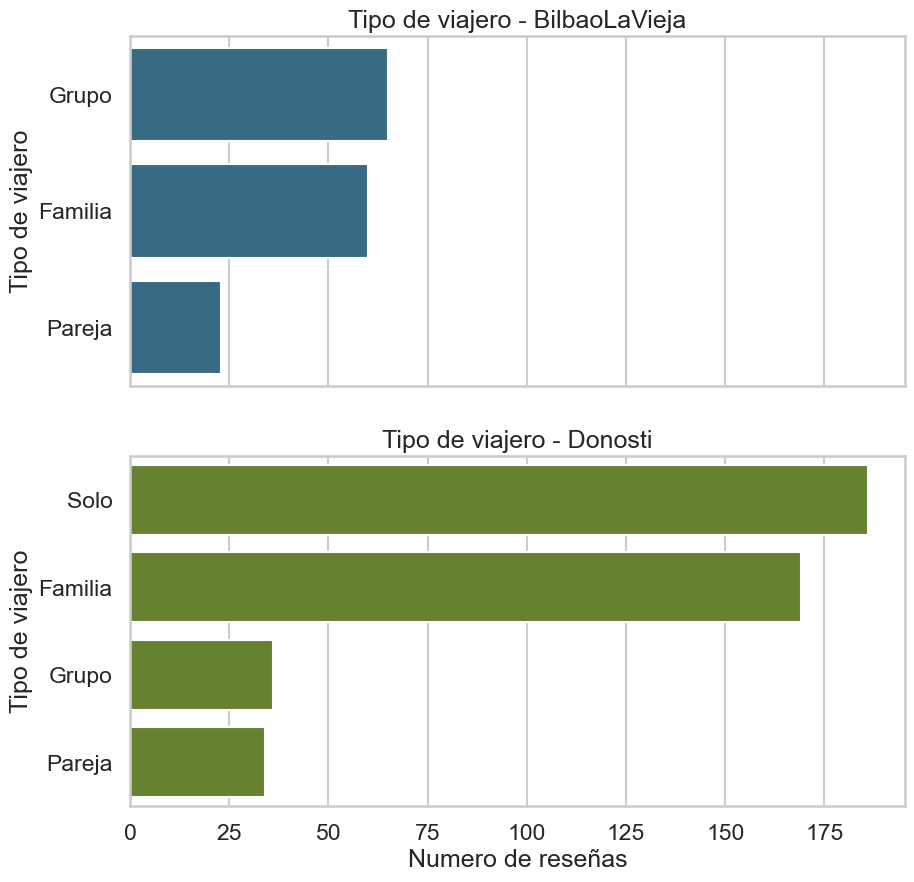

In [38]:
sns.set(style="whitegrid", context="talk")

# Tipo Viajero
def extraer_tipo_viajero(etiquetas):
    etiquetas = str(etiquetas).lower()

    if "persona que viaja sola" in etiquetas:
        return "Solo"
    if "pareja" in etiquetas:
        return "Pareja"
    if "familia" in etiquetas:
        return "Familia"
    if "grupo" in etiquetas:
        return "Grupo"
    if "negocios" in etiquetas:
        return "Negocios"
    return "Otros"

df["tipo_viajero"] = df["etiquetas"].apply(extraer_tipo_viajero)

# Global

conteo_general = (
    df["tipo_viajero"]
    .value_counts()
    .reset_index()
)
conteo_general.columns = ["tipo_viajero", "num_reseñas"]

plt.figure(figsize=(8, 6))
sns.barplot(
    data=conteo_general,
    x="num_reseñas",
    y="tipo_viajero",
    color=paleta[8]   
)

plt.title("Tipo de viajero - Global")
plt.xlabel("Numero de reseñas")
plt.ylabel("Tipo de viajero")
plt.show()


#Hotel
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for i, hotel in enumerate(hoteles):

    df_hotel = df[df["ubicacion"] == hotel]

    conteo_viajero = (
        df_hotel["tipo_viajero"]
        .value_counts()
        .reset_index()
    )
    conteo_viajero.columns = ["tipo_viajero", "num_reseñas"]

    sns.barplot(
        data=conteo_viajero,
        x="num_reseñas",
        y="tipo_viajero",
        ax=axes[i],
        color=color_por_ubicacion[hotel]
    )

    axes[i].set_title(f"Tipo de viajero - {hotel}")
    axes[i].set_xlabel("Numero de reseñas")
    axes[i].set_ylabel("Tipo de viajero")

plt.show()
